The purpose of this notebook is to run tests on the hyperparameters of autoencoding mixed with the Siamese network to have improved downstream performance.

### TLDR: hyperparameter tweaking yields no significant downstream performance improvement.

# Baseline

Hypothesis: We might be representation bottlenecked and that might be contributing to our less than ideal performance. What if we start by pretraining our network to do autoencoding, chop off the decoder, and then do our metric learning on that

In [2]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from sklearn.decomposition import PCA
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [3]:
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [4]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

wikitext_acts = torch.load('generics_kb_10k_10272024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

C:\Users\hayde\AppData\Local\Temp\ipykernel_36724\167593289.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_train  = torch.load('gpt2_medium_train_acts_1.npy')
C:\

 10%|██████▊                                                             | 10/100 [01:02<09:29,  6.32s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Late: 8.338
Test Losses  - Early: 1.163, Mid: 4.034, Late: 22.649


 20%|█████████████▌                                                      | 20/100 [02:06<08:37,  6.47s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.580, Late: 4.964
Test Losses  - Early: 1.034, Mid: 3.464, Late: 16.784


 30%|████████████████████▍                                               | 30/100 [03:10<07:29,  6.43s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.459, Late: 3.769
Test Losses  - Early: 0.966, Mid: 3.196, Late: 14.704


 40%|███████████████████████████▏                                        | 40/100 [04:15<06:28,  6.47s/it]


Epoch 40
Train Losses - Early: 0.089, Mid: 0.374, Late: 3.151
Test Losses  - Early: 0.933, Mid: 3.050, Late: 13.833


 50%|██████████████████████████████████                                  | 50/100 [05:19<05:20,  6.42s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.319, Late: 2.604
Test Losses  - Early: 0.922, Mid: 2.971, Late: 12.995


 60%|████████████████████████████████████████▊                           | 60/100 [06:22<04:14,  6.37s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.276, Late: 2.341
Test Losses  - Early: 0.912, Mid: 2.915, Late: 12.481


 70%|███████████████████████████████████████████████▌                    | 70/100 [07:26<03:09,  6.30s/it]


Epoch 70
Train Losses - Early: 0.049, Mid: 0.248, Late: 2.023
Test Losses  - Early: 0.912, Mid: 2.883, Late: 11.994


 80%|██████████████████████████████████████████████████████▍             | 80/100 [08:28<02:07,  6.38s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.231, Late: 1.835
Test Losses  - Early: 0.913, Mid: 2.867, Late: 11.715


 90%|█████████████████████████████████████████████████████████████▏      | 90/100 [09:31<01:04,  6.43s/it]


Epoch 90
Train Losses - Early: 0.040, Mid: 0.218, Late: 1.710
Test Losses  - Early: 0.917, Mid: 2.854, Late: 11.548


100%|███████████████████████████████████████████████████████████████████| 100/100 [10:34<00:00,  6.35s/it]


Epoch 100
Train Losses - Early: 0.037, Mid: 0.200, Late: 1.496
Test Losses  - Early: 0.917, Mid: 2.821, Late: 11.178


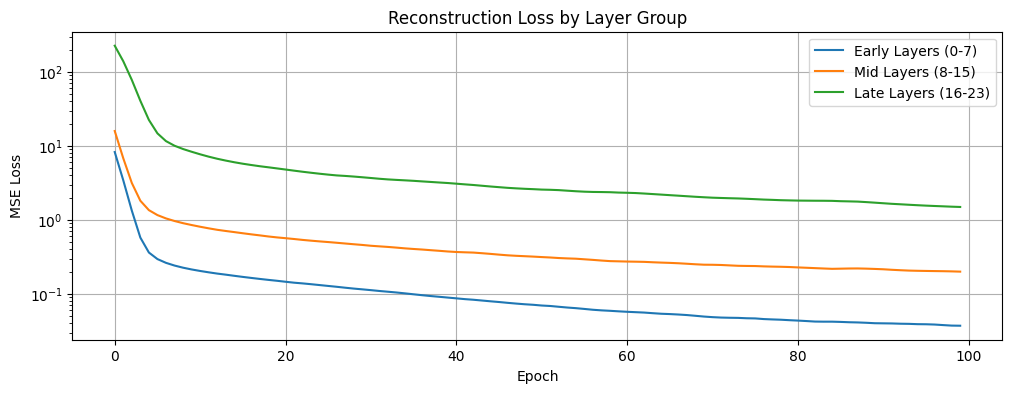

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Experimentation at All Layers

The experiment here is to see if creating a more complex architecture for later layers can help decrease the major loss discrepany we are currently seeing. First off, this will require a simple modification to the init for Autoencoder to create a more complex architecture for late layers. Second, if that shows promise, the complexity of late can be "hand me downed" to the mid layers and the late layers become even more complex. If either situations look like they need even more help, in the get_hidden function the return of the scaling of how many hidden layers to use can be amped to be even larger for later ones. Also, the learning rate is being increase naively for each layer, we could instead introduce a system of a learning rate scheduler, eg. ReduceLROnPlateau, which would decrease the learning rate upon plateaued loss. Or, in general the starting point and alteration of learning rate between layers should be explored, stored, and analyzed in isolation after trying the architecture changes.

There is also the possibility that GELU is not appropriate for later layers since some activation functions might have better feature represenations at deeper layers. A potential thought here is to replace the Gaussian Error Linear Unit (GELU) for later layers with ReLU or LeakyReLU.

## Increasingly complex architecture implementation and results

The only difference here is in the init of the Autoencoder class

 10%|█         | 10/100 [01:57<17:56, 11.96s/it]


Epoch 10
Train Losses - Early: 0.215, Mid: 0.852, Late: 10.183
Test Losses  - Early: 1.165, Mid: 4.037, Late: 24.971


 20%|██        | 20/100 [03:52<15:20, 11.51s/it]


Epoch 20
Train Losses - Early: 0.151, Mid: 0.578, Late: 6.229
Test Losses  - Early: 1.037, Mid: 3.463, Late: 19.165


 30%|███       | 30/100 [05:48<13:29, 11.56s/it]


Epoch 30
Train Losses - Early: 0.116, Mid: 0.454, Late: 4.890
Test Losses  - Early: 0.967, Mid: 3.194, Late: 17.540


 40%|████      | 40/100 [07:43<11:28, 11.48s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Late: 4.116
Test Losses  - Early: 0.932, Mid: 3.062, Late: 16.564


 50%|█████     | 50/100 [09:37<09:32, 11.44s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Late: 3.588
Test Losses  - Early: 0.913, Mid: 2.967, Late: 16.852


 60%|██████    | 60/100 [11:31<07:39, 11.50s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.280, Late: 3.226
Test Losses  - Early: 0.910, Mid: 2.940, Late: 15.874


 70%|███████   | 70/100 [13:25<05:43, 11.46s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.248, Late: 2.939
Test Losses  - Early: 0.913, Mid: 2.895, Late: 16.096


 80%|████████  | 80/100 [15:19<03:49, 11.45s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.228, Late: 2.686
Test Losses  - Early: 0.908, Mid: 2.871, Late: 15.818


 90%|█████████ | 90/100 [17:16<01:59, 11.99s/it]


Epoch 90
Train Losses - Early: 0.040, Mid: 0.215, Late: 2.454
Test Losses  - Early: 0.912, Mid: 2.867, Late: 16.603


100%|██████████| 100/100 [19:11<00:00, 11.51s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Late: 2.312
Test Losses  - Early: 0.918, Mid: 2.859, Late: 15.784


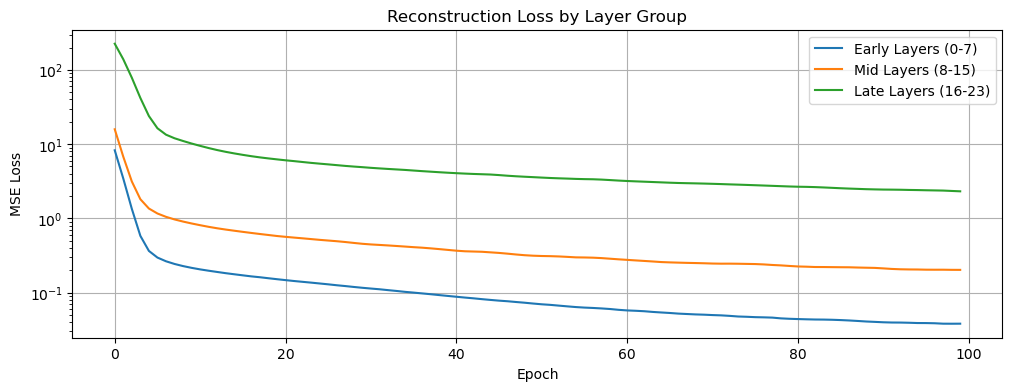

In [6]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        # More gradual dimension reduction for late layers, also affords more layers
        # this is the one third point, this is closer to d_in
        d_onethird_to_hidden = (2 * d_in + d_hidden) // 3 
        # this is the two third point, this is closer to d_hidden
        d_twothird_to_hidden = (d_in + 2 * d_hidden) // 3
        
        # This is a modest enhancement of complexity
        if layer_idx >= 16:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_in)
            )
        # For early and mid keep the original architecture
        else:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_in)
            )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Marginally worse

## Hidden layer increase

The only different here is in the get_hidden function.

 10%|█         | 10/100 [01:49<16:24, 10.94s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Late: 7.543
Test Losses  - Early: 1.163, Mid: 4.037, Late: 21.336


 20%|██        | 20/100 [03:38<14:34, 10.93s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.583, Late: 4.481
Test Losses  - Early: 1.037, Mid: 3.477, Late: 16.006


 30%|███       | 30/100 [05:27<12:42, 10.90s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.458, Late: 3.446
Test Losses  - Early: 0.964, Mid: 3.198, Late: 14.206


 40%|████      | 40/100 [07:15<10:49, 10.83s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Late: 2.662
Test Losses  - Early: 0.936, Mid: 3.050, Late: 13.263


 50%|█████     | 50/100 [09:06<09:33, 11.47s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Late: 2.274
Test Losses  - Early: 0.919, Mid: 2.961, Late: 12.524


 60%|██████    | 60/100 [11:02<07:49, 11.74s/it]


Epoch 60
Train Losses - Early: 0.059, Mid: 0.280, Late: 1.861
Test Losses  - Early: 0.915, Mid: 2.915, Late: 11.927


 70%|███████   | 70/100 [12:56<05:44, 11.49s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.247, Late: 1.640
Test Losses  - Early: 0.914, Mid: 2.875, Late: 11.224


 80%|████████  | 80/100 [14:50<03:51, 11.57s/it]


Epoch 80
Train Losses - Early: 0.045, Mid: 0.230, Late: 1.445
Test Losses  - Early: 0.913, Mid: 2.866, Late: 11.006


 90%|█████████ | 90/100 [16:45<01:55, 11.50s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.213, Late: 1.260
Test Losses  - Early: 0.915, Mid: 2.836, Late: 10.563


100%|██████████| 100/100 [18:41<00:00, 11.21s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Late: 1.130
Test Losses  - Early: 0.913, Mid: 2.833, Late: 10.381


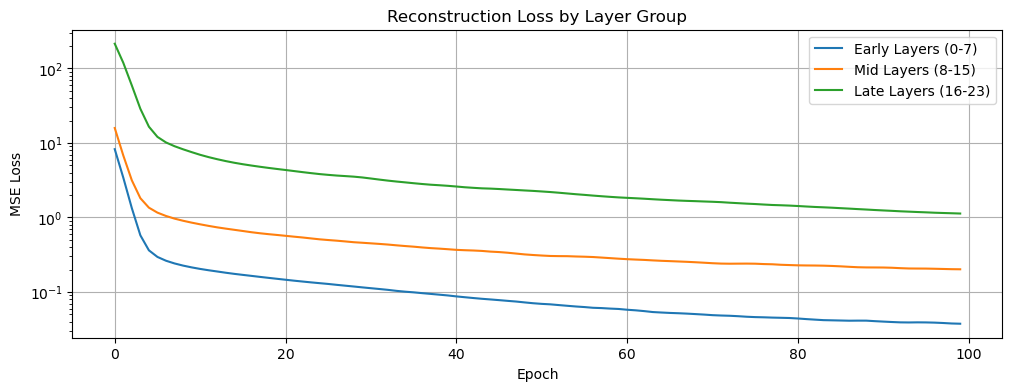

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 5  # Increased from 3 to 5
    else:
        return 6  # Increased from 4 to 6

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU()
        )
            
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in)
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Marginally better

# Experimentation on the Final Four Layers

The final four layers have the highest loss and are capturing the most complex information, so apply hyperparameter experimentation to improve their loss.

## Baseline

 10%|█         | 10/100 [01:50<16:27, 10.97s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Mid Late: 2.979, Final Four: 13.695
Test Losses  - Early: 1.163, Mid: 4.037, Mid Late: 11.082, Final Four: 34.228


 20%|██        | 20/100 [03:37<14:35, 10.95s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.583, Mid Late: 1.957, Final Four: 7.951
Test Losses  - Early: 1.037, Mid: 3.477, Mid Late: 9.405, Final Four: 24.093


 30%|███       | 30/100 [05:21<12:15, 10.50s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.458, Mid Late: 1.543, Final Four: 5.990
Test Losses  - Early: 0.964, Mid: 3.198, Mid Late: 8.584, Final Four: 20.930


 40%|████      | 40/100 [07:05<10:25, 10.43s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Mid Late: 1.274, Final Four: 4.957
Test Losses  - Early: 0.936, Mid: 3.050, Mid Late: 8.087, Final Four: 19.399


 50%|█████     | 50/100 [08:49<08:40, 10.40s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Mid Late: 1.100, Final Four: 4.224
Test Losses  - Early: 0.919, Mid: 2.961, Mid Late: 7.807, Final Four: 18.560


 60%|██████    | 60/100 [10:33<06:59, 10.48s/it]


Epoch 60
Train Losses - Early: 0.059, Mid: 0.280, Mid Late: 0.958, Final Four: 3.664
Test Losses  - Early: 0.915, Mid: 2.915, Mid Late: 7.587, Final Four: 17.448


 70%|███████   | 70/100 [12:17<05:13, 10.44s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.247, Mid Late: 0.874, Final Four: 3.230
Test Losses  - Early: 0.914, Mid: 2.875, Mid Late: 7.495, Final Four: 16.945


 80%|████████  | 80/100 [14:01<03:29, 10.46s/it]


Epoch 80
Train Losses - Early: 0.045, Mid: 0.230, Mid Late: 0.775, Final Four: 2.957
Test Losses  - Early: 0.913, Mid: 2.866, Mid Late: 7.368, Final Four: 16.461


 90%|█████████ | 90/100 [15:45<01:44, 10.42s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.213, Mid Late: 0.724, Final Four: 2.712
Test Losses  - Early: 0.915, Mid: 2.836, Mid Late: 7.317, Final Four: 15.881


100%|██████████| 100/100 [17:31<00:00, 10.51s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Mid Late: 0.667, Final Four: 2.362
Test Losses  - Early: 0.913, Mid: 2.833, Mid Late: 7.277, Final Four: 15.251


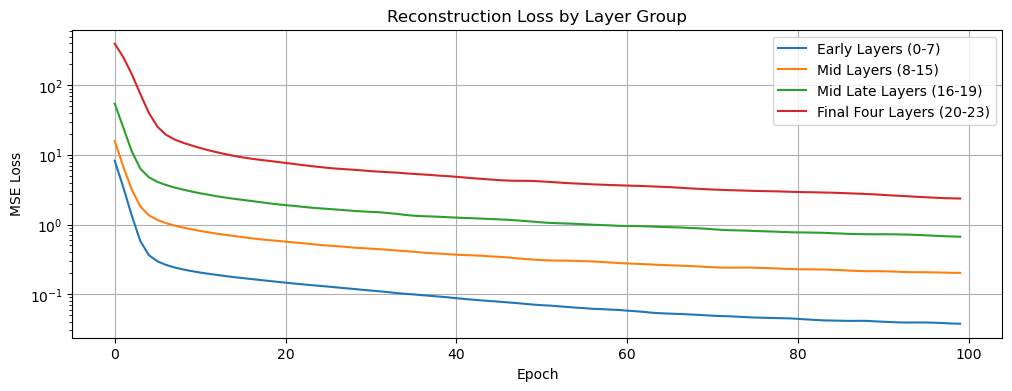

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

## Increase Hidden Layers for Final Four

The change here is in get_hidden

 10%|█         | 10/100 [01:50<16:15, 10.84s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Mid Late: 2.979, Final Four: 12.149
Test Losses  - Early: 1.163, Mid: 4.037, Mid Late: 11.082, Final Four: 31.184


 20%|██        | 20/100 [03:37<14:20, 10.75s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.583, Mid Late: 1.957, Final Four: 7.240
Test Losses  - Early: 1.037, Mid: 3.477, Mid Late: 9.405, Final Four: 22.921


 30%|███       | 30/100 [05:25<12:33, 10.76s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.458, Mid Late: 1.543, Final Four: 5.547
Test Losses  - Early: 0.964, Mid: 3.198, Mid Late: 8.584, Final Four: 20.175


 40%|████      | 40/100 [07:12<10:43, 10.72s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Mid Late: 1.274, Final Four: 4.467
Test Losses  - Early: 0.936, Mid: 3.050, Mid Late: 8.087, Final Four: 19.346


 50%|█████     | 50/100 [08:59<08:55, 10.70s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Mid Late: 1.100, Final Four: 3.720
Test Losses  - Early: 0.919, Mid: 2.961, Mid Late: 7.807, Final Four: 17.664


 60%|██████    | 60/100 [10:46<07:08, 10.72s/it]


Epoch 60
Train Losses - Early: 0.059, Mid: 0.280, Mid Late: 0.958, Final Four: 3.195
Test Losses  - Early: 0.915, Mid: 2.915, Mid Late: 7.587, Final Four: 17.122


 70%|███████   | 70/100 [12:33<05:20, 10.69s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.247, Mid Late: 0.874, Final Four: 2.749
Test Losses  - Early: 0.914, Mid: 2.875, Mid Late: 7.495, Final Four: 16.343


 80%|████████  | 80/100 [14:20<03:33, 10.68s/it]


Epoch 80
Train Losses - Early: 0.045, Mid: 0.230, Mid Late: 0.775, Final Four: 2.389
Test Losses  - Early: 0.913, Mid: 2.866, Mid Late: 7.368, Final Four: 15.701


 90%|█████████ | 90/100 [16:09<01:47, 10.71s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.213, Mid Late: 0.724, Final Four: 2.099
Test Losses  - Early: 0.915, Mid: 2.836, Mid Late: 7.317, Final Four: 14.821


100%|██████████| 100/100 [17:54<00:00, 10.74s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Mid Late: 0.667, Final Four: 1.897
Test Losses  - Early: 0.913, Mid: 2.833, Mid Late: 7.277, Final Four: 14.352


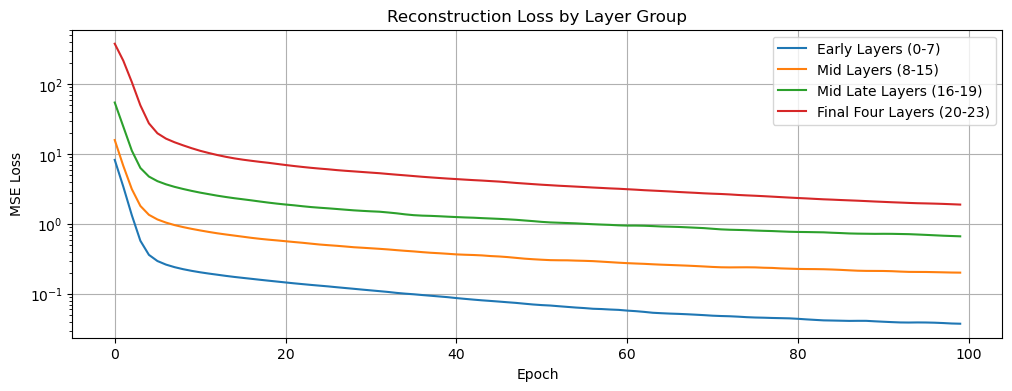

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 19:
        return 3
    elif i == 20:
        return 4
    elif i == 21:
        return 5
    elif i == 22:
        return 6
    else:
        return 7

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: marginal improvement

## Increase Activation Layers for Final Four

The change here is in the init of Autoencoder

 10%|█         | 10/100 [01:49<16:28, 10.98s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.852, Mid Late: 3.000, Final Four: 17.412
Test Losses  - Early: 1.164, Mid: 4.035, Mid Late: 11.103, Final Four: 38.309


 20%|██        | 20/100 [03:38<14:35, 10.94s/it]


Epoch 20
Train Losses - Early: 0.151, Mid: 0.582, Mid Late: 1.982, Final Four: 10.352
Test Losses  - Early: 1.033, Mid: 3.468, Mid Late: 9.473, Final Four: 28.240


 30%|███       | 30/100 [05:30<13:18, 11.41s/it]


Epoch 30
Train Losses - Early: 0.116, Mid: 0.458, Mid Late: 1.555, Final Four: 7.999
Test Losses  - Early: 0.963, Mid: 3.201, Mid Late: 8.594, Final Four: 25.132


 40%|████      | 40/100 [07:22<11:18, 11.30s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.381, Mid Late: 1.276, Final Four: 6.821
Test Losses  - Early: 0.930, Mid: 3.063, Mid Late: 8.045, Final Four: 24.229


 50%|█████     | 50/100 [09:15<09:24, 11.30s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.319, Mid Late: 1.070, Final Four: 6.055
Test Losses  - Early: 0.914, Mid: 2.975, Mid Late: 7.666, Final Four: 23.911


 60%|██████    | 60/100 [11:07<07:30, 11.27s/it]


Epoch 60
Train Losses - Early: 0.059, Mid: 0.283, Mid Late: 0.972, Final Four: 5.273
Test Losses  - Early: 0.906, Mid: 2.921, Mid Late: 7.543, Final Four: 23.016


 70%|███████   | 70/100 [13:00<05:38, 11.27s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.250, Mid Late: 0.851, Final Four: 4.859
Test Losses  - Early: 0.906, Mid: 2.876, Mid Late: 7.343, Final Four: 22.854


 80%|████████  | 80/100 [14:52<03:44, 11.24s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.232, Mid Late: 0.782, Final Four: 4.492
Test Losses  - Early: 0.904, Mid: 2.858, Mid Late: 7.226, Final Four: 23.093


 90%|█████████ | 90/100 [16:44<01:52, 11.24s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.215, Mid Late: 0.717, Final Four: 4.064
Test Losses  - Early: 0.909, Mid: 2.845, Mid Late: 7.145, Final Four: 22.488


100%|██████████| 100/100 [18:36<00:00, 11.17s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.203, Mid Late: 0.689, Final Four: 3.814
Test Losses  - Early: 0.916, Mid: 2.835, Mid Late: 7.205, Final Four: 23.091


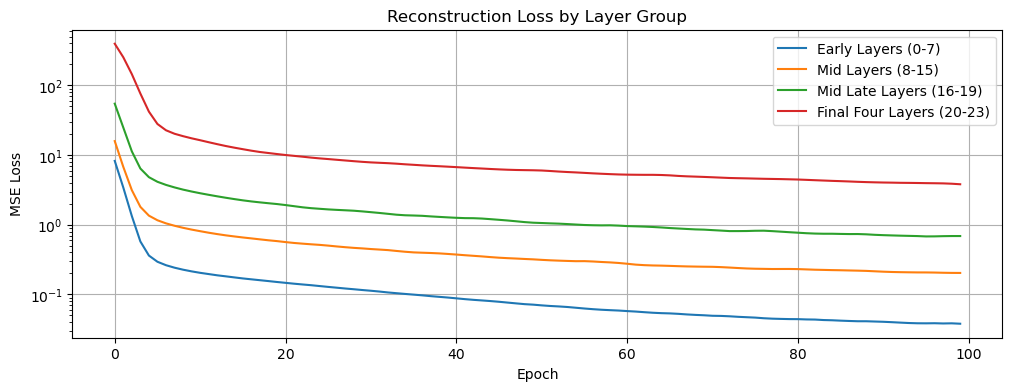

In [5]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        # More gradual dimension reduction for late layers, also affords more layers
        # this is the one third point, this is closer to d_in
        d_onethird_to_hidden = (2 * d_in + d_hidden) // 3 
        # this is the two third point, this is closer to d_hidden
        d_twothird_to_hidden = (d_in + 2 * d_hidden) // 3
        
        # This is a modest enhancement of complexity
        if layer_idx >= 20:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_twothird_to_hidden),
                nn.LayerNorm(d_twothird_to_hidden),
                nn.GELU(),
                nn.Linear(d_twothird_to_hidden, d_onethird_to_hidden),
                nn.LayerNorm(d_onethird_to_hidden),
                nn.GELU(),
                nn.Linear(d_onethird_to_hidden, d_in)
            )
        # For early and mid keep the original architecture
        else:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_in)
            )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Significantly worse

## Modify Learning Rate for Final Four

The change here is in the definition of lrs

 10%|█         | 10/100 [01:43<15:39, 10.44s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.850, Mid Late: 2.993, Final Four: 10.546
Test Losses  - Early: 1.163, Mid: 4.027, Mid Late: 11.117, Final Four: 27.455


 20%|██        | 20/100 [03:25<13:36, 10.21s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.578, Mid Late: 1.944, Final Four: 6.810
Test Losses  - Early: 1.035, Mid: 3.471, Mid Late: 9.350, Final Four: 22.033


 30%|███       | 30/100 [05:07<11:54, 10.21s/it]


Epoch 30
Train Losses - Early: 0.116, Mid: 0.459, Mid Late: 1.527, Final Four: 5.188
Test Losses  - Early: 0.967, Mid: 3.213, Mid Late: 8.533, Final Four: 19.682


 40%|████      | 40/100 [06:48<10:08, 10.15s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.381, Mid Late: 1.284, Final Four: 4.195
Test Losses  - Early: 0.933, Mid: 3.078, Mid Late: 8.103, Final Four: 18.337


 50%|█████     | 50/100 [08:31<08:53, 10.67s/it]


Epoch 50
Train Losses - Early: 0.072, Mid: 0.321, Mid Late: 1.108, Final Four: 3.522
Test Losses  - Early: 0.916, Mid: 2.980, Mid Late: 7.783, Final Four: 17.848


 60%|██████    | 60/100 [10:13<06:51, 10.28s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.273, Mid Late: 0.966, Final Four: 2.975
Test Losses  - Early: 0.915, Mid: 2.905, Mid Late: 7.568, Final Four: 16.503


 70%|███████   | 70/100 [11:55<05:07, 10.24s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.253, Mid Late: 0.852, Final Four: 2.566
Test Losses  - Early: 0.910, Mid: 2.885, Mid Late: 7.401, Final Four: 15.694


 80%|████████  | 80/100 [13:37<03:23, 10.19s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.227, Mid Late: 0.805, Final Four: 2.319
Test Losses  - Early: 0.909, Mid: 2.862, Mid Late: 7.387, Final Four: 15.502


 90%|█████████ | 90/100 [15:19<01:42, 10.21s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.212, Mid Late: 0.713, Final Four: 2.103
Test Losses  - Early: 0.914, Mid: 2.835, Mid Late: 7.212, Final Four: 15.320


100%|██████████| 100/100 [17:01<00:00, 10.22s/it]


Epoch 100
Train Losses - Early: 0.037, Mid: 0.206, Mid Late: 0.673, Final Four: 1.901
Test Losses  - Early: 0.911, Mid: 2.832, Mid Late: 7.175, Final Four: 15.171


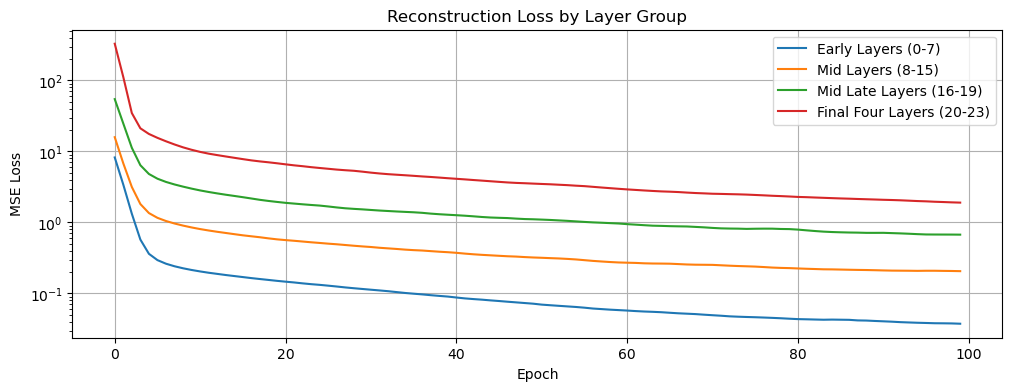

In [6]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i / 24) for i in range(n_layers)]
lrs[20:] = [lr * 2 for lr in lrs[20:]]  # Double the learning rate for the final four layers
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Marginal improvement

## Add More Dropout for Final Four

The change here is in the init of Autoencoder

 10%|█         | 10/100 [01:44<15:41, 10.46s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.851, Mid Late: 2.971, Final Four: 19.604
Test Losses  - Early: 1.163, Mid: 4.035, Mid Late: 11.055, Final Four: 39.000


 20%|██        | 20/100 [03:28<13:57, 10.47s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.582, Mid Late: 1.960, Final Four: 15.000
Test Losses  - Early: 1.032, Mid: 3.456, Mid Late: 9.381, Final Four: 30.837


 30%|███       | 30/100 [05:12<12:12, 10.46s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.460, Mid Late: 1.535, Final Four: 13.687
Test Losses  - Early: 0.965, Mid: 3.192, Mid Late: 8.574, Final Four: 28.539


 40%|████      | 40/100 [06:58<10:43, 10.73s/it]


Epoch 40
Train Losses - Early: 0.089, Mid: 0.382, Mid Late: 1.277, Final Four: 12.996
Test Losses  - Early: 0.933, Mid: 3.063, Mid Late: 8.073, Final Four: 26.906


 50%|█████     | 50/100 [08:42<08:43, 10.46s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.321, Mid Late: 1.119, Final Four: 12.502
Test Losses  - Early: 0.919, Mid: 2.975, Mid Late: 7.873, Final Four: 25.949


 60%|██████    | 60/100 [10:27<07:00, 10.51s/it]


Epoch 60
Train Losses - Early: 0.058, Mid: 0.281, Mid Late: 0.956, Final Four: 12.052
Test Losses  - Early: 0.911, Mid: 2.917, Mid Late: 7.522, Final Four: 25.232


 70%|███████   | 70/100 [12:12<05:16, 10.57s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.254, Mid Late: 0.859, Final Four: 11.712
Test Losses  - Early: 0.909, Mid: 2.889, Mid Late: 7.401, Final Four: 24.776


 80%|████████  | 80/100 [13:57<03:30, 10.52s/it]


Epoch 80
Train Losses - Early: 0.044, Mid: 0.231, Mid Late: 0.774, Final Four: 11.380
Test Losses  - Early: 0.913, Mid: 2.861, Mid Late: 7.252, Final Four: 24.326


 90%|█████████ | 90/100 [15:42<01:45, 10.53s/it]


Epoch 90
Train Losses - Early: 0.040, Mid: 0.216, Mid Late: 0.748, Final Four: 11.102
Test Losses  - Early: 0.910, Mid: 2.831, Mid Late: 7.415, Final Four: 24.130


100%|██████████| 100/100 [17:26<00:00, 10.47s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Mid Late: 0.650, Final Four: 10.862
Test Losses  - Early: 0.916, Mid: 2.823, Mid Late: 7.113, Final Four: 23.709


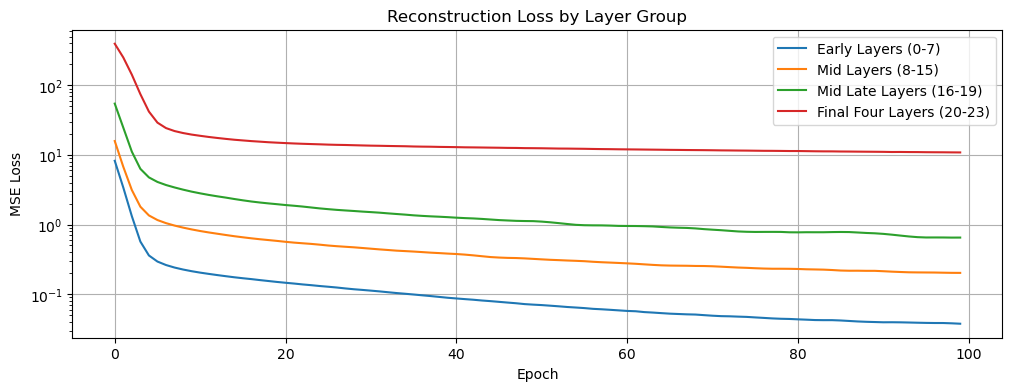

In [7]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_prob = 0.3):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction for early and middle layers
        d_mid = (d_in + d_hidden) // 2

        
        # This is a modest enhancement of complexity
        if layer_idx >= 20:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Dropout(dropout_prob), # DROPOUT
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU(),
                nn.Dropout(dropout_prob) # DROPOUT
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Dropout(dropout_prob), # DROPOUT
                nn.Linear(d_mid, d_in)
            )
        # For early and mid keep the original architecture
        else:
            self.encode = nn.Sequential(
                nn.Linear(d_in, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_hidden),
                nn.LayerNorm(d_hidden),
                nn.GELU()
            )
            
            self.decode = nn.Sequential(
                nn.Linear(d_hidden, d_mid),
                nn.LayerNorm(d_mid),
                nn.GELU(),
                nn.Linear(d_mid, d_in)
            )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        return self.decode(h) + 0.1 * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Significantly worse

## Residual Connections with Larger Scaling

The change here is in the forward function of Autoencoder, also had to initialize layer_idx in init

 10%|█         | 10/100 [01:39<14:59,  9.99s/it]


Epoch 10
Train Losses - Early: 0.214, Mid: 0.853, Mid Late: 2.979, Final Four: 3.115
Test Losses  - Early: 1.163, Mid: 4.037, Mid Late: 11.082, Final Four: 8.660


 20%|██        | 20/100 [03:20<13:25, 10.07s/it]


Epoch 20
Train Losses - Early: 0.150, Mid: 0.583, Mid Late: 1.957, Final Four: 1.930
Test Losses  - Early: 1.037, Mid: 3.477, Mid Late: 9.405, Final Four: 6.625


 30%|███       | 30/100 [05:01<11:46, 10.10s/it]


Epoch 30
Train Losses - Early: 0.115, Mid: 0.458, Mid Late: 1.543, Final Four: 1.455
Test Losses  - Early: 0.964, Mid: 3.198, Mid Late: 8.584, Final Four: 5.894


 40%|████      | 40/100 [06:40<09:57,  9.96s/it]


Epoch 40
Train Losses - Early: 0.090, Mid: 0.375, Mid Late: 1.274, Final Four: 1.175
Test Losses  - Early: 0.936, Mid: 3.050, Mid Late: 8.087, Final Four: 5.525


 50%|█████     | 50/100 [08:20<08:21, 10.02s/it]


Epoch 50
Train Losses - Early: 0.071, Mid: 0.314, Mid Late: 1.100, Final Four: 1.061
Test Losses  - Early: 0.919, Mid: 2.961, Mid Late: 7.807, Final Four: 5.342


 60%|██████    | 60/100 [10:01<06:47, 10.20s/it]


Epoch 60
Train Losses - Early: 0.059, Mid: 0.280, Mid Late: 0.958, Final Four: 0.871
Test Losses  - Early: 0.915, Mid: 2.915, Mid Late: 7.587, Final Four: 5.109


 70%|███████   | 70/100 [11:43<05:04, 10.13s/it]


Epoch 70
Train Losses - Early: 0.050, Mid: 0.247, Mid Late: 0.874, Final Four: 0.784
Test Losses  - Early: 0.914, Mid: 2.875, Mid Late: 7.495, Final Four: 4.939


 80%|████████  | 80/100 [13:25<03:23, 10.17s/it]


Epoch 80
Train Losses - Early: 0.045, Mid: 0.230, Mid Late: 0.775, Final Four: 0.710
Test Losses  - Early: 0.913, Mid: 2.866, Mid Late: 7.368, Final Four: 4.988


 90%|█████████ | 90/100 [15:05<01:40, 10.02s/it]


Epoch 90
Train Losses - Early: 0.041, Mid: 0.213, Mid Late: 0.724, Final Four: 0.672
Test Losses  - Early: 0.915, Mid: 2.836, Mid Late: 7.317, Final Four: 4.958


100%|██████████| 100/100 [16:45<00:00, 10.05s/it]


Epoch 100
Train Losses - Early: 0.038, Mid: 0.202, Mid Late: 0.667, Final Four: 0.590
Test Losses  - Early: 0.913, Mid: 2.833, Mid Late: 7.277, Final Four: 4.644


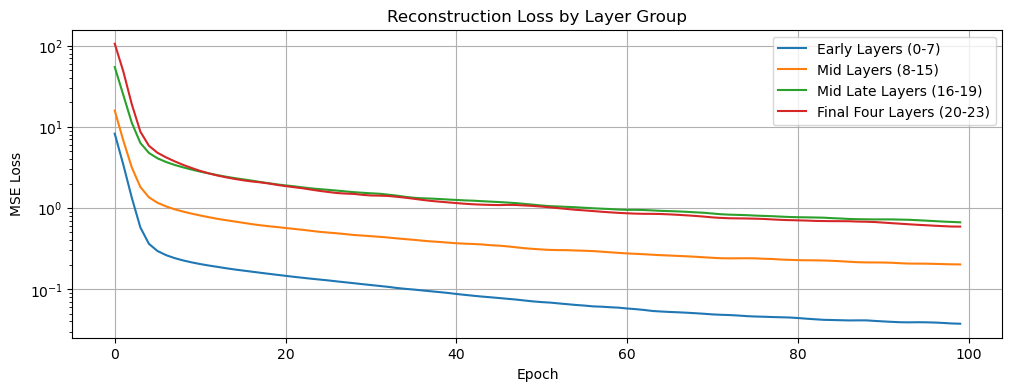

In [5]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # need to init layer id
        self.layer_idx = layer_idx

        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        # Add residual connection for easier learning
        # keep the normal scaling for all but the final four
        if self.layer_idx >= 20:
            residual_scale = 0.5
        else:
            residual_scale = 0.1

        return self.decode(h) + residual_scale * x  # Scaled residual to start mostly from identity

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Significantly better, HOWEVER:

While this is interesting, it violates the purpose of this project. We are trying to learn a good representation, so having a residual connection is like telling the encoder to compress the input, but know that it'll get half of it later. Which, in this case, is essentially cheating.

## Best of Experiments: Enhanced Learning Rate and More Hidden Layers

Removed the residual connection in forward since it is technically cheating. Since all prior experiments had the same level of cheating, their results are still considered the same for what experiments rendered improvements.

### Baseline without residual connection

 10%|█         | 10/100 [01:43<16:01, 10.68s/it]


Epoch 10
Train Losses - Early: 0.273, Mid: 1.098, Mid Late: 3.850, Final Four: 17.935
Test Losses  - Early: 1.452, Mid: 5.061, Mid Late: 13.907, Final Four: 44.005


 20%|██        | 20/100 [03:23<13:14,  9.93s/it]


Epoch 20
Train Losses - Early: 0.192, Mid: 0.745, Mid Late: 2.546, Final Four: 10.132
Test Losses  - Early: 1.292, Mid: 4.363, Mid Late: 11.838, Final Four: 30.850


 30%|███       | 30/100 [05:02<11:30,  9.87s/it]


Epoch 30
Train Losses - Early: 0.149, Mid: 0.594, Mid Late: 1.986, Final Four: 7.730
Test Losses  - Early: 1.200, Mid: 4.006, Mid Late: 10.682, Final Four: 26.794


 40%|████      | 40/100 [06:41<09:54,  9.91s/it]


Epoch 40
Train Losses - Early: 0.118, Mid: 0.494, Mid Late: 1.664, Final Four: 6.333
Test Losses  - Early: 1.154, Mid: 3.822, Mid Late: 10.167, Final Four: 24.699


 50%|█████     | 50/100 [08:20<08:13,  9.87s/it]


Epoch 50
Train Losses - Early: 0.095, Mid: 0.416, Mid Late: 1.428, Final Four: 5.444
Test Losses  - Early: 1.128, Mid: 3.702, Mid Late: 9.680, Final Four: 23.169


 60%|██████    | 60/100 [09:58<06:38,  9.95s/it]


Epoch 60
Train Losses - Early: 0.078, Mid: 0.365, Mid Late: 1.259, Final Four: 4.706
Test Losses  - Early: 1.123, Mid: 3.622, Mid Late: 9.417, Final Four: 21.909


 70%|███████   | 70/100 [11:37<04:55,  9.86s/it]


Epoch 70
Train Losses - Early: 0.066, Mid: 0.323, Mid Late: 1.114, Final Four: 4.202
Test Losses  - Early: 1.121, Mid: 3.583, Mid Late: 9.198, Final Four: 20.783


 80%|████████  | 80/100 [13:17<03:19,  9.98s/it]


Epoch 80
Train Losses - Early: 0.058, Mid: 0.298, Mid Late: 1.041, Final Four: 3.812
Test Losses  - Early: 1.117, Mid: 3.546, Mid Late: 9.082, Final Four: 20.391


 90%|█████████ | 90/100 [14:55<01:38,  9.88s/it]


Epoch 90
Train Losses - Early: 0.053, Mid: 0.276, Mid Late: 0.917, Final Four: 3.290
Test Losses  - Early: 1.120, Mid: 3.517, Mid Late: 8.971, Final Four: 19.536


100%|██████████| 100/100 [16:33<00:00,  9.94s/it]


Epoch 100
Train Losses - Early: 0.049, Mid: 0.259, Mid Late: 0.877, Final Four: 3.069
Test Losses  - Early: 1.118, Mid: 3.503, Mid Late: 8.928, Final Four: 19.207


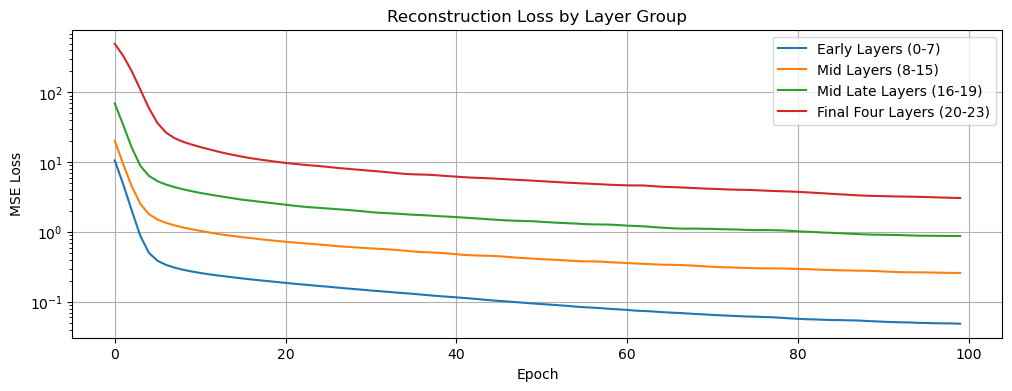

In [8]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 20:
        return 3
    else:
        return 4

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Compared to experimental combinations

 10%|█         | 10/100 [01:42<15:16, 10.18s/it]


Epoch 10
Train Losses - Early: 0.273, Mid: 1.093, Mid Late: 3.871, Final Four: 12.774
Test Losses  - Early: 1.452, Mid: 5.061, Mid Late: 13.968, Final Four: 33.161


 20%|██        | 20/100 [03:24<13:39, 10.24s/it]


Epoch 20
Train Losses - Early: 0.192, Mid: 0.745, Mid Late: 2.546, Final Four: 8.145
Test Losses  - Early: 1.291, Mid: 4.341, Mid Late: 11.866, Final Four: 27.127


 30%|███       | 30/100 [05:07<12:06, 10.38s/it]


Epoch 30
Train Losses - Early: 0.149, Mid: 0.594, Mid Late: 1.988, Final Four: 6.066
Test Losses  - Early: 1.202, Mid: 4.000, Mid Late: 10.726, Final Four: 24.090


 40%|████      | 40/100 [06:49<10:09, 10.16s/it]


Epoch 40
Train Losses - Early: 0.118, Mid: 0.491, Mid Late: 1.648, Final Four: 4.763
Test Losses  - Early: 1.152, Mid: 3.821, Mid Late: 10.051, Final Four: 21.822


 50%|█████     | 50/100 [08:29<08:26, 10.12s/it]


Epoch 50
Train Losses - Early: 0.094, Mid: 0.417, Mid Late: 1.489, Final Four: 3.961
Test Losses  - Early: 1.133, Mid: 3.708, Mid Late: 9.945, Final Four: 21.246


 60%|██████    | 60/100 [10:10<06:44, 10.11s/it]


Epoch 60
Train Losses - Early: 0.078, Mid: 0.370, Mid Late: 1.246, Final Four: 3.345
Test Losses  - Early: 1.121, Mid: 3.625, Mid Late: 9.430, Final Four: 20.306


 70%|███████   | 70/100 [11:51<05:01, 10.06s/it]


Epoch 70
Train Losses - Early: 0.066, Mid: 0.323, Mid Late: 1.149, Final Four: 2.828
Test Losses  - Early: 1.124, Mid: 3.561, Mid Late: 9.328, Final Four: 19.089


 80%|████████  | 80/100 [13:32<03:22, 10.13s/it]


Epoch 80
Train Losses - Early: 0.058, Mid: 0.303, Mid Late: 1.024, Final Four: 2.468
Test Losses  - Early: 1.121, Mid: 3.559, Mid Late: 9.200, Final Four: 18.521


 90%|█████████ | 90/100 [15:14<01:41, 10.17s/it]


Epoch 90
Train Losses - Early: 0.053, Mid: 0.275, Mid Late: 0.950, Final Four: 2.229
Test Losses  - Early: 1.123, Mid: 3.502, Mid Late: 9.012, Final Four: 18.941


100%|██████████| 100/100 [16:55<00:00, 10.16s/it]


Epoch 100
Train Losses - Early: 0.049, Mid: 0.263, Mid Late: 0.865, Final Four: 1.995
Test Losses  - Early: 1.123, Mid: 3.497, Mid Late: 8.956, Final Four: 17.937


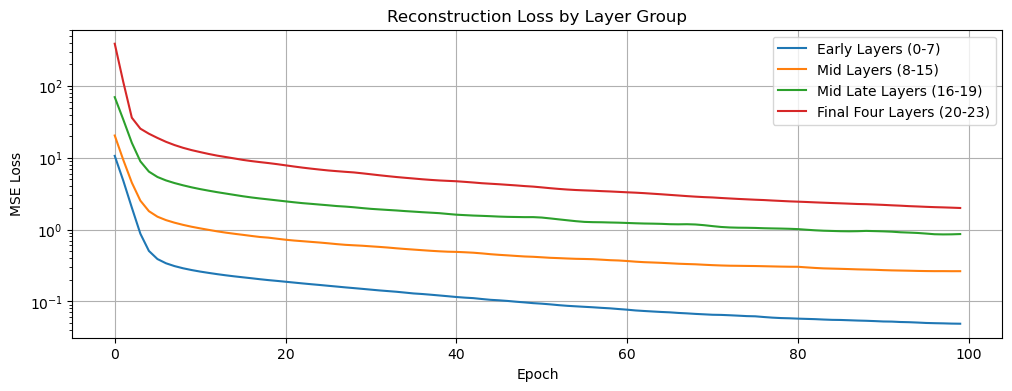

In [9]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i <= 8:
        return 1
    elif i <= 16:
        return 2
    elif i <= 19:
        return 3
    elif i == 20:
        return 4
    elif i == 21:
        return 5
    elif i == 22:
        return 6
    else:
        return 7

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.GELU(),
            nn.Linear(d_mid, d_in),
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h) 

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i / 24) for i in range(n_layers)]
lrs[20:] = [lr * 2 for lr in lrs[20:]]  # Double the learning rate for the final four layers
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    losses = []
    n_batches = acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
mid_late_layers_history = []
final_four_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    mid_late_layers_history.append(np.mean(losses[16:20]))
    final_four_layers_history.append(np.mean(losses[20:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Mid Late: {mid_late_layers_history[-1]:.3f}, "
                  f"Final Four: {final_four_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Mid Late: {np.mean(test_losses[16:20]):.3f}, "
                  f"Final Four: {np.mean(test_losses[20:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(mid_late_layers_history, label='Mid Late Layers (16-19)')
plt.plot(final_four_layers_history, label='Final Four Layers (20-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Result: Roughly 5% improvement over baseline

# Incorporating Improvements in Downstream Results

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [11]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = first_acts[start_idx:end_idx].cuda()
        x2_batch = second_acts[start_idx:end_idx].cuda()
        scores_batch = scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(100)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

 10%|█         | 10/100 [02:12<19:54, 13.27s/it]

Epoch 10
Loss: 0.0163
Train correlation: 0.8855
Test correlation: 0.6955



 20%|██        | 20/100 [04:23<17:42, 13.28s/it]

Epoch 20
Loss: 0.0079
Train correlation: 0.9366
Test correlation: 0.7117



 30%|███       | 30/100 [06:35<15:31, 13.31s/it]

Epoch 30
Loss: 0.0076
Train correlation: 0.9469
Test correlation: 0.6900



 40%|████      | 40/100 [08:45<13:04, 13.08s/it]

Epoch 40
Loss: 0.0034
Train correlation: 0.9604
Test correlation: 0.7260



 50%|█████     | 50/100 [10:56<10:56, 13.12s/it]

Epoch 50
Loss: 0.0030
Train correlation: 0.9563
Test correlation: 0.7131



 60%|██████    | 60/100 [13:09<08:51, 13.28s/it]

Epoch 60
Loss: 0.0025
Train correlation: 0.9550
Test correlation: 0.6845



 70%|███████   | 70/100 [15:20<06:39, 13.30s/it]

Epoch 70
Loss: 0.0033
Train correlation: 0.9781
Test correlation: 0.7368



 80%|████████  | 80/100 [17:30<04:20, 13.01s/it]

Epoch 80
Loss: 0.0013
Train correlation: 0.9774
Test correlation: 0.7081



 90%|█████████ | 90/100 [19:39<02:10, 13.01s/it]

Epoch 90
Loss: 0.0009
Train correlation: 0.9877
Test correlation: 0.7266



100%|██████████| 100/100 [21:48<00:00, 13.08s/it]

Epoch 100
Loss: 0.0011
Train correlation: 0.9871
Test correlation: 0.7406



In [12]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

tensor(0.7406, grad_fn=<SelectBackward0>)


In [14]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 34263041 parameters!'

### End result: 4 million more parameters and no significant difference in downstream performance improvement. Overall, hyperparameter tweaking yields no significant downstream performance improvement.